----
# Image Encryption Scheme Based on a Generalized Arnold Map and RSA Algorithm
----
Kaixin Jiao,1 Guodong Ye ,1 Youxia Dong,1 Xiaoling Huang,1 and Jianqing He1

Programming: Maciej Piotrowski and Sergiusz Kański 


https://www.hindawi.com/journals/scn/2020/9721675/


In [101]:
import random
import numpy as np
from PIL import Image
import imageio
import matplotlib.pyplot as plt 
from scipy.stats import entropy
from collections import Counter
import math
import random

----
## 0. Methods to display
----


In [102]:
def convertTo1d(tab_2d):
  tab_1d = []
  x=tab_2d.shape[0]**2
  for j in range(0,tab_2d.shape[0]):
      for i in range(0,tab_2d.shape[0]):
          tab_1d.append(tab_2d[j][i])
          x-=1
      if(x<=0):
          break
  return tab_1d

def display(image,image2,text="",text2=""):
    figImg, axsImg = plt.subplots(1,2,figsize = [12, 12])
    axsImg[0].set_title(text)
    axsImg[1].set_title(text2)
    axsImg[0].imshow(image     ,cmap=plt.cm.gray, vmin=0, vmax=255)
    axsImg[1].imshow(image2     ,cmap=plt.cm.gray, vmin=0, vmax=255)
    
def displayHist(image,image2,text="",text2=""):
    image=convertTo1d(image)
    image2=convertTo1d(image2)
    figImg, axsImg = plt.subplots(1,2,figsize = [12,6])
    axsImg[0].set_title(text)
    axsImg[0].set_xlabel("Wartość próbki")
    axsImg[0].set_ylabel("Prawdopodobieństwo na wystąpienie próbki o danej wartości")
    axsImg[1].set_xlabel("Wartość próbki")
    axsImg[1].set_ylabel("Prawdopodobieństwo na wystąpienie próbki o danej wartości")
    axsImg[1].set_title(text2)
    axsImg[0].hist(image    , density=True,bins=256, range=[0, 255])
    axsImg[1].hist(image2    , density=True,bins=256, range=[0, 255])



----
## 1. Entropy counting
----


In [103]:
def numberDict(array):
  cnt = Counter()
  for number in array:
    cnt[number] += 1
  return cnt,len(array)  
          
         
def entropy(array):
  array=convertTo1d(array)
  dict,len = numberDict(array)
  entropy = 0
  
  for number in dict:
    entropy += -(dict[number]/len) * math.log2(dict[number]/len)
    
  return entropy



----
## 2. RSA Algorythm 
----


In [104]:
def getGcd(x, y):
  while(y):
      x, y = y, x % y
  return x


def getRsa(p,q):
  phi_of_n = (p - 1) * (q - 1)
  e=random.randint(2,phi_of_n)
  while(getGcd(e,phi_of_n)!=1):
    e=random.randint(2,phi_of_n)
  d=pow(e,-1)%phi_of_n
  return e,d

def RSA(p,q):
  n=p*q

  e,d = getRsa(p,q)

  x01 = random.randint(0,1000)
  x02 = random.randint(0,1000)
  x03 = random.randint(0,1000)
  x04 = random.randint(0,1000)

  y01 = x01 + x02
  y02 = x02 + x03
  y03 = x03 + x04
  y04 = x01 + x04

  c01 = pow(y01,e)%n
  c02 = pow(y02,e)%n
  c03 = pow(y03,e)%n
  c04 = pow(y04,e)%n


  return np.fix(x01+np.sqrt(np.log(c01+y01))),np.fix(x02+np.sqrt(np.log(c02+y02))),np.fix(x03+np.sqrt(np.log(c03+y03))),np.fix(x04+np.sqrt(np.log(c04+y04)))#return a1,a2,b1,b2


----
## 3. Arnold Map Algorythm 
----


In [105]:
def ArnoldMap(a,b,P):
    N=P.shape[0]
    x,y = np.meshgrid(range(N),range(N))
    X = (x+b*y) % N
    Y = (a*x+y*(a*b+1)) % N
    P=P[X,Y]
    C=P
    return C

----
## 4. Generate S and R chaotic sequences
----


In [106]:
def GenerateChaoticSequences(P,p=11,q=19):
    a1,b1,a2,b2 = RSA(p,q)
    s=ArnoldMap(int(a1),int(b1),P)
    r=ArnoldMap(int(a2),int(b2),P)
    S=P.ravel()
    R=P.ravel()
    for i in range(0,P[0].size):
            for j in range(0,P[0].size):
                S[i+j] = ((np.floor((s[i][j]+100)*(10**14)))%256)

    for i in range(0,P[0].size):
            for j in range(0,P[0].size):
                R[i+j] = ((np.floor((r[i][j]+100)*(10**14)))%256)
    return S,R

----
## 5. Record the plain image as P and perform the following XOR diffusion operation with the generated key stream S to obtain image A:
----


In [107]:
def obtainImageA(P,S):
    P = P.ravel()
    A = P.ravel()
    for i in range(0,A.size-1):
        A[i]=0
    A[0] = np.bitwise_xor(P[0],S[0])

    for i in range(1,A.size-1):
        A[i]=np.bitwise_xor(A[i-1],np.bitwise_xor(P[i],S[i]))

    return A



----
## 6. Transform S into a matrix. Then, take the first row and first column of the image matrix S and conduct cyclic scrambling of the row and column directions of image A to obtain image B
----


In [108]:

def scrambling(S,A):
    S=S.reshape(A[0].size,A[0].size)
    

    X=np.empty(A[0].size)
    for i in range(0,A[0].size):
        X[i]=S[0][i]
    X.sort()

    Y=np.empty(A[0].size)
    for i in range(0,A[0].size):
        Y[i]=S[i][0]
    Y.sort()


    B=np.bitwise_xor(A,S)
    #C=B.copy()

    for i in range(0,A[0].size):
        for j in range(0,A[0].size):
            B[i][j] = B[X[i].astype(int)][Y[j].astype(int)]

    return B



----
## 7. Image B and chaotic sequence R are used to perform an additive mode diffusion operation to obtain image C
----


In [109]:
def obtainImageC(B,R): 
    size=B[0].size
    B=B.ravel()
    C=np.empty((B.size))

    C[0]=(B[0]+R[0])%255

    for i in range(1,B.size):
        C[i] = (C[i-1]+B[i]+R[i])%256
    C=C.reshape(size,size)
    return C

## 8. Encryption Image

Entropy for original: 7.4447487844965465
Entropy after 1 cycles algorithm: 7.99691621807576
Entropy after 2 cycles algorithm: 7.999236203329476


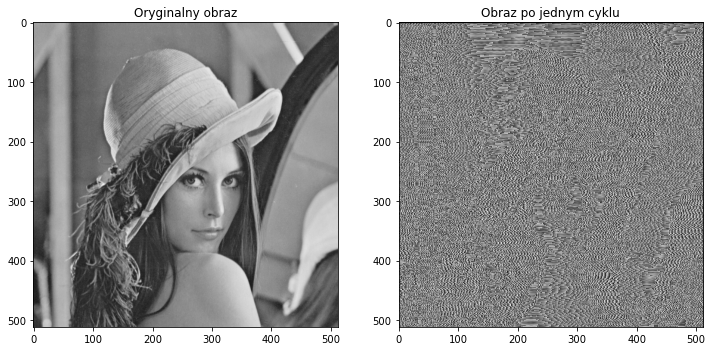

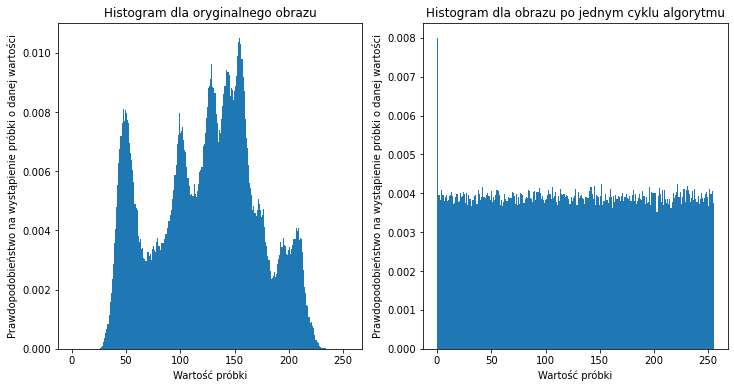

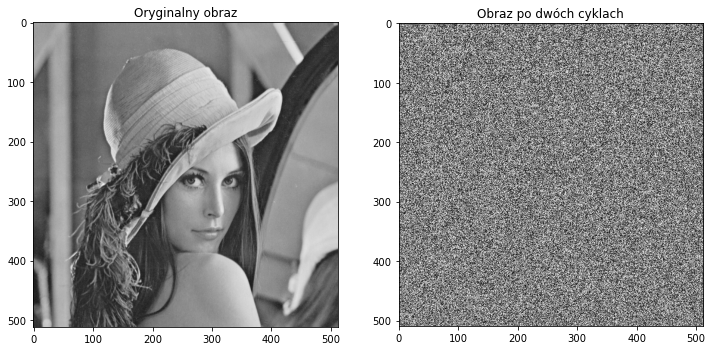

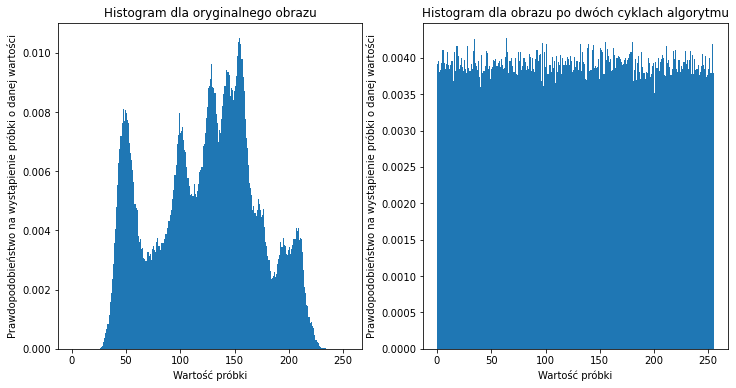

In [116]:
def Encryption(imageToEncrypt):
    p=11
    q=19
    S,R=GenerateChaoticSequences(imageToEncrypt.copy(),p,q)
    A=obtainImageA(imageToEncrypt.copy(),S)
    B=scrambling(S,A.reshape(imageToEncrypt[0].size,imageToEncrypt[0].size))
    C=obtainImageC(B,R)
    return C

file = "lena.png"
imageToEncrypt = imageio.imread(file)


#Wyniki po pierwszym cyklu
C=Encryption(imageToEncrypt.copy())
display(imageToEncrypt,C,"Oryginalny obraz", "Obraz po jednym cyklu")
displayHist(imageToEncrypt,C,"Histogram dla oryginalnego obrazu","Histogram dla obrazu po jednym cyklu algorytmu")
print("Entropy for original:",entropy(imageToEncrypt))
print("Entropy after 1 cycles algorithm:",entropy(C))


imageio.imwrite('temp.png',C.astype(np.uint8))
temp = imageio.imread('temp.png')
C=Encryption(temp.copy())

C=np.delete(C,0,0)
C=np.delete(C,0,0)
#Wyniki po drugim cyklu
display(imageToEncrypt,C,"Oryginalny obraz","Obraz po dwóch cyklach")
displayHist(imageToEncrypt,C,"Histogram dla oryginalnego obrazu","Histogram dla obrazu po dwóch cyklach algorytmu")
print("Entropy after 2 cycles algorithm:",entropy(C))

#imageio.imwrite('final.png',C.astype(np.uint8))
    